In [4]:
# imports
import pandas as p                              # pandas
import numpy as np                              # numpy
import datetime as dt                           # datetime module for time intervals
from sklearn.cluster import DBSCAN              # DBSCAN algorithm
from sklearn.cluster import HDBSCAN             # HDBSCAN algorithm
import hdbscan as hdbs                          # improved (faster) HDBSCAN https://github.com/scikit-learn-contrib/hdbscan, https://joss.theoj.org/papers/10.21105/joss.00205
import matplotlib.pyplot as plt                 # plot
import gc                                       # garbage collector
from scipy.spatial import ConvexHull            # ConvexHulls for clusters
from shapely.geometry.polygon import Polygon    # for operations on clusters

# map plotting
import shapely as shpl               
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go


# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-03.csv'
SPEED_THRESHOLD = 0.5 # nautical knots
ABSURD_SPEED_THRESHOLD = 102 # nautical knots
POINTS_THRESHOLD = 50
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, taken from WGS-84 standard and used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
LOST_TIME_THRESHOLD_SECONDS = dt.timedelta(seconds=620) # 10 * (62s)
EXIT_TIME_THRESHOLD_HOURS = dt.timedelta(hours=12) # half day

Import source csv into a dataframe

In [5]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)
print(clean_df.shape)

/tmp/ipykernel_9143/4039637272.py:1: DtypeWarning:

Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.



Dataframe shape: (5415168, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')
(5415168, 17)


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [6]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - No action. Just want to make sure to not loose precision 
optimized_df['LAT'] = clean_df['LAT']

# LON - No action. Just want to make sure to not loose precision 
optimized_df['LON'] = clean_df['LON']

# SOG - No action
optimized_df['SOG'] = clean_df['SOG']

# COG - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 360 degrees, relative to true north
optimized_df['COG'] = clean_df['COG'].astype('float32')

# Heading - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 511, meaning 'no data'.
optimized_df['Heading'] = clean_df['Heading'].astype('float32')

# VesselName - specify string dtype
optimized_df['VesselName'] = clean_df['VesselName'].astype(p.StringDtype())

# IMO - specify string dtype
optimized_df['IMO'] = clean_df['IMO'].astype(p.StringDtype())

# CallSign - specify string dtype
optimized_df['CallSign'] = clean_df['CallSign'].astype(p.StringDtype())

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

# Round lat and lon values to 4 decimal digits (instead of 5)
optimized_df[['LAT','LON']] = optimized_df[['LAT','LON']].round(4)

print(clean_df.info())

print(optimized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 702.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTim

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [7]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Vectorized function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)
optimized_df = optimized_df.sort_values(by='BaseDateTime')

reference_list_of_mmsi = p.unique(optimized_df['MMSI']).tolist()
reference_list_of_mmsi.sort()

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# for each ship
for mmsi in reference_list_of_mmsi:
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = p.Series(dtype=p.Float64Dtype())
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points. (SOG is not always reliable)
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON', 'SOG']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()

    # sometimes a vessel can stop reporting its position and re-appear too far away from its last known location.
    # In this case it makes little sense to calculate the avg_speed. (np.nan multiplied by any number returns np.nan)
    
    # condition used to determine if the ship is "lost"
    lost_condition = (pairsOfPointsDF['DeltaTime'] > LOST_TIME_THRESHOLD_SECONDS)
    # another codition used to determine if the ship has left the domain for a significant amount of time
    exit_condition = (pairsOfPointsDF['DeltaTime'] > EXIT_TIME_THRESHOLD_HOURS)
    # the avg_speed of the points following the ones considered "lost" 
    # (which includes also vessels that satisfy the Exit condition) is set to nan
    pairsOfPointsDF.loc[lost_condition, 'Speed'] = np.nan
    # any nan point of the 'Speed' column is set to the corresponging 'SOG' value (if available and reliable)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].fillna(
                                                                p.Series(
                                                                    np.where((  pairsOfPointsDF['SOG'] < ABSURD_SPEED_THRESHOLD), #if I have to rely on the SOG, check if it is plausible (verosimile)
                                                                                pairsOfPointsDF['SOG']/KNOTS_CONST, # if yes, use the SOG value (converted in m/s)
                                                                                pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds() # if no, calculate it again
                                                                            )))
    
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    pairsOfPointsDF['EstimatedStatus'] = p.Series(dtype=p.StringDtype())

    # set the status of the last and first points before (lost) and after (return) a small interruption
    pairsOfPointsDF.loc[lost_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'lost'
    pairsOfPointsDF.loc[lost_condition, 'EstimatedStatus'] = 'return'
    # set the status of the last and first points before (exit) and after (entry) a big interruption
    pairsOfPointsDF.loc[exit_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'exit'
    pairsOfPointsDF.loc[exit_condition, 'EstimatedStatus'] = 'entry'

    # convert the speed from meters to nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    # round the final value to 2 decimal digits
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG (due to lazyness this time the reliability of the SOG value is not checked)
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # Any row where avg_speed is set to np.nan is replaced with the SOG value
    appendDF.fillna({'Avg_Speed' : appendDF['SOG']}, inplace=True)    
    
    # Sometimes a vessel may broadcast an impossible GPS location. This is detected by looking for 
    # absurd values in the freshly calculated 'Avg_Speed' field. Any point that fits this description is then dropped.
    appendDF = appendDF[appendDF['Avg_Speed'] < ABSURD_SPEED_THRESHOLD]
    
    # Copy the estimated status column in the final ship df
    appendDF['EstimatedStatus'] = pairsOfPointsDF['EstimatedStatus'].copy()

    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.name = str(mmsi)
    appendDF._metadata += ['name'] # this is necessary otherwise copying the dataframe will make it loose its name (why? ask Pandas, I don't know)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

display(V_s[-1].head())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus
0,981000633,2019-02-04 01:48:04,22.4414,-158.3415,5.5,187.000000,511.0,<NA>,0,99,0,0,NaN,False,5.50,<NA>
1,981000633,2019-02-04 01:50:37,22.4373,-158.3419,5.8,174.100006,511.0,<NA>,0,99,0,0,NaN,False,5.82,<NA>
2,981000633,2019-02-04 01:53:05,22.4333,-158.3421,6.6,177.199997,511.0,<NA>,0,99,0,0,NaN,False,5.85,<NA>
3,981000633,2019-02-04 01:55:32,22.4294,-158.3424,5.6,180.300003,511.0,<NA>,0,99,0,0,NaN,False,5.76,<NA>
4,981000633,2019-02-04 01:58:07,22.4251,-158.3426,6.5,167.800003,511.0,<NA>,0,99,0,0,NaN,False,6.01,<NA>


In [8]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

0

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

Removed duplicate entry or exit point at index [1336].
Previous ship len: 1359
Current ship len: 1358
Removed duplicate entry or exit point at index [1460].
Previous ship len: 1826
Current ship len: 1825
Removed duplicate entry or exit point at index [796].
Previous ship len: 6316
Current ship len: 6315
Removed duplicate entry or exit point at index [655, 656].
Previous ship len: 1081
Current ship len: 1079
Removed duplicate entry or exit point at index [2269].
Previous ship len: 3408
Current ship len: 3407
Removed duplicate entry or exit point at index [3873].
Previous ship len: 7827
Current ship len: 7826
Removed duplicate entry or exit point at index [3531].
Previous ship len: 35098
Current ship len: 35097
Removed duplicate entry or exit point at index [17898, 17899].
Previous ship len: 23549
Current ship len: 23547
Removed duplicate entry or exit point at index [0].
Previous ship len: 2190
Current ship len: 2189
Removed duplicate entry or exit point at index [1476].
Previous ship l

,MMSI,BaseDateTime,SOG,Avg_Speed,EstimatedStatus
1600,9108942,2019-01-21 08:46:06,6.1,6.03,sailing
1601,9108942,2019-01-21 08:47:32,6.5,6.04,sailing
1602,9108942,2019-01-21 08:49:02,6.0,6.26,sailing
1603,9108942,2019-01-21 08:50:34,5.8,6.12,sailing
1604,9108942,2019-01-21 08:52:06,5.8,6.12,sailing
1605,9108942,2019-01-21 08:53:57,5.8,6.04,sailing
1606,9108942,2019-01-21 08:55:06,6.3,5.99,sailing
1607,9108942,2019-01-21 08:56:35,6.2,6.32,sailing
1608,9108942,2019-01-21 08:58:04,5.5,6.08,sailing
1609,9108942,2019-01-21 08:59:35,5.8,6.18,sailing


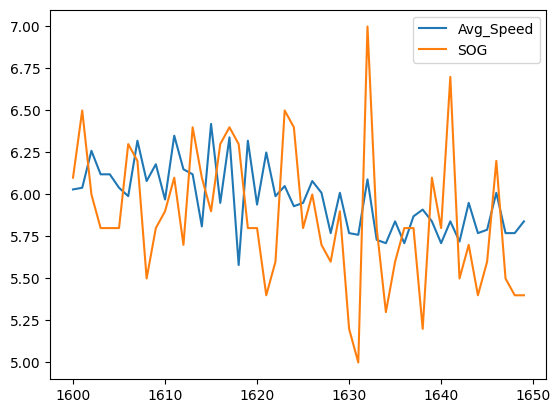

In [9]:
# for each vessel (dataframe) in the V_s list,
for index, shipDF in enumerate(V_s):
    # check that the ships are read in the same order
    if shipDF.name != str(reference_list_of_mmsi[index]):
        print('Error with ships order')

    # set the status of each point where the avg_speed is lower than the given threshold to 'stationary'
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] <= SPEED_THRESHOLD) &
                                         (shipDF['EstimatedStatus'].isnull())),
                                         'stationary', shipDF['EstimatedStatus'])
    # set all remaining null points as "sailing"
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] > SPEED_THRESHOLD) & 
                                         (shipDF['EstimatedStatus'].isnull())),
                                          'sailing', shipDF['EstimatedStatus'])
    # set the first and last points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:1], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-1:], 'EstimatedStatus'] = 'exit'
    
    # sometimes a few consecutive points (for the same vessel) might be all with status 'entry' or 'exit'
    # this is unwanted and only one of those points is kept.
    # The rule is: keep the last of any consecutive 'entry' point and keep the first of any consecutive 'exit' point
    
    tempDF = shipDF[(shipDF['EstimatedStatus'] == 'entry') | (shipDF['EstimatedStatus'] == 'exit')] 

    condition_entry  = (
                        (tempDF['EstimatedStatus'] == 'entry') &
                        (tempDF['EstimatedStatus'].shift(-1) == tempDF['EstimatedStatus'])
                        )
    condition_exit =(
                        (tempDF['EstimatedStatus'] == 'exit') &
                        (tempDF['EstimatedStatus'].shift(1) == tempDF['EstimatedStatus'])
                    )
    # save the index of rows that need to be removed
    bad_entry_index = tempDF[condition_entry].index.to_list()
    bad_exit_index = tempDF[condition_exit].index.to_list()
    # if any of the above list is not empty
    if bad_entry_index or bad_exit_index:
        final_bad_index = bad_entry_index + bad_exit_index
        final_bad_index.sort()
        print(f'Removed duplicate entry or exit point at index {final_bad_index}.')
        print(f'Previous ship len: {shipDF.shape[0]}')
        shipDF = shipDF.drop(index=final_bad_index).reset_index()
        print(f'Current ship len: {shipDF.shape[0]}')
    # update the list of vessel with the updated values
    V_s[index] = shipDF

del shipDF
del tempDF
gc.collect()

# print a dataframe and some points just to check the result
interval = range(1600,1650)
display(V_s[3].loc[interval, ['MMSI', 'BaseDateTime', 'SOG', 'Avg_Speed', 'EstimatedStatus']].head(10))
plt.plot(V_s[3].loc[interval,'Avg_Speed'])
plt.plot(V_s[3].loc[interval,'SOG'])
plt.legend(['Avg_Speed', 'SOG'])


In [10]:
# aggregate all the points back into a single dataframe
concatDF = p.concat(V_s, ignore_index=True).copy()

# Extract all the stationary points in a single dataframe
stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

# stationary points include all points that are useful for extracting routes
stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF.reset_index(inplace=True)

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

 69.56% of points are stationary!


In [11]:
# Some computationl tricks in order to save some time
print(f'Currently there are {stationaryDF.shape[0]} stationary points!')
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')
print(f'The new df has {groupedDF.shape[0]} rows!')
print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is arbitrarly replaced
groupedDF['Weight'] = groupedDF['Weight'].replace(0,1)

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Currently there are 3766844 stationary points!
The new df has 51801 rows!
Pair with most occurrencies: 
LAT          21.2970
LON        -158.1065
Weight    61877.0000
Name: 36636, dtype: float64



,LAT,LON,Weight
0,18.7665,-155.7773,1.0
1,18.7666,-156.9702,1.0
2,18.7669,-156.6011,1.0
3,18.7669,-156.5696,1.0
4,18.7671,-159.1110,1.0
51796,22.6307,-156.9234,1.0
51797,22.6307,-156.3146,1.0
51798,22.6308,-158.4875,1.0
51799,22.6308,-156.8662,1.0
51800,22.6308,-155.5218,1.0


Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     16.0000
Name: 36636, dtype: float64



DBSCAN(eps=0.075, min_samples=10) len: 51801, num of clusters: 54


,LAT,LON,Weight,Label
0,18.7665,-155.7773,1.0,1
1,18.7666,-156.9702,1.0,-1
2,18.7669,-156.6011,1.0,-1
3,18.7669,-156.5696,1.0,-1
4,18.7671,-159.1110,1.0,-1
51796,22.6307,-156.9234,1.0,-1
51797,22.6307,-156.3146,1.0,-1
51798,22.6308,-158.4875,1.0,-1
51799,22.6308,-156.8662,1.0,49
51800,22.6308,-155.5218,1.0,54


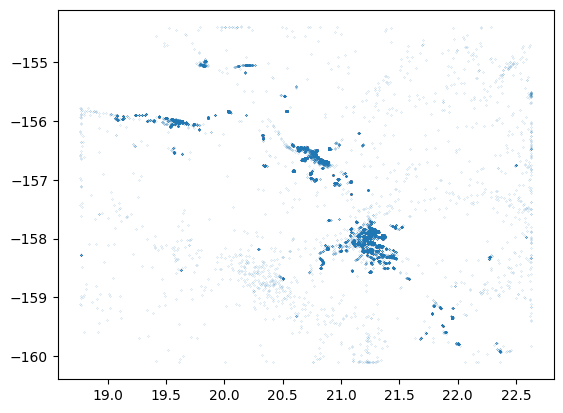

In [12]:
# Run DBSCAN algorithm on the grouped stationary points

# this scatter plot gives a rough idea of how the points should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.075, min_samples=10)

estimator = dbscan.fit(
                       X=groupedDF.iloc[:, 0:2], 
                       sample_weight=groupedDF['Weight']
                      )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

In [13]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)

def points_plotter(clustered : p.DataFrame, not_clustered : p.DataFrame, model, dbscanFlag : bool):
    '''Function used to plot the results of dbscan and hdbscan\n
    Takes as input two dataframes: clusterd and not_clustered, both containing
    points that were successfully labelled or not, respectively.
    dbscanFlag = True specifies that the label are created using the DBSCAN algo. If set to False, that H-DBSCAN was used'''
    if dbscanFlag:
        my_title = 'DBSCAN. Eps: ' + str(model.get_params()['eps']) + ', min_size: ' + str(model.get_params()['min_samples'])
    else:
        my_title = 'H-DBSCAN. Min Eps: ' + str(model.get_params()['cluster_selection_epsilon']) + \
            ', min_size: ' + str(model.get_params()['min_cluster_size']) + \
            ', max_size: ' + str(model.get_params()['max_cluster_size'])
    
    # plot clustered points on a map
    fig = px.scatter_mapbox(data_frame = clustered,
                            lon = clustered['LON'],
                            lat= clustered['LAT'],
                            zoom = 7,
                            color = clustered['Label'],
                            title = my_title,
                            color_continuous_scale='portland'  #portland
                            )

    # add unclustered points
    fig.add_scattermapbox(
                          lat= not_clustered['LAT'],
                          lon= not_clustered['LON'],
                          marker={'color':'white'},
                          uid=1
                          )

    # add domain border
    fig.add_trace(go.Scattermapbox(
                                    mode = 'lines',
                                    lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                    lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                    marker = {'size':10,
                                              'color': 'red'},
                                    uid=2,
                                    below=0
                                    ))
    
    # Add polygons on map
    for label in clustered['Label'].unique():
        groupLATLONDF = clustered[clustered['Label']==label][['LAT', 'LON']]
        hull = ConvexHull(groupLATLONDF)
        hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
        hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]
    
        hull_lon = [serie.tolist()[1] for serie in hull_lon]
        hull_lat = [serie.tolist()[1] for serie in hull_lat]
    
        fig.add_trace(go.Scattermapbox(
            lat=hull_lat + [hull_lat[0]],
            lon=hull_lon + [hull_lon[0]],
            mode='lines',
            line=dict(color='black', width=2),
            below=0,
            showlegend=False,
            name='WP_' + str(label)
            #fill='toself',
            #fillcolor='rgba(255,0,0,0.2)'
        ))

    fig.update_layout(mapbox_style = 'open-street-map',
                      margin={'r':0, 't':40, 'l':0, 'b':0},
                      )
    po.plot(fig)

    

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()
outliersDF = groupedDF[groupedDF['Label'] == -1].copy()
clusteredPointsDF.reset_index(inplace=True)
outliersDF.reset_index(inplace=True)

display(p.concat([clusteredPointsDF.head(5), clusteredPointsDF.tail(5)]))

points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=estimator,
               dbscanFlag=True)



,index,LAT,LON,Weight,Label
0,0,18.7665,-155.7773,1.0,1
1,7,18.7673,-155.9327,1.0,1
2,10,18.7677,-155.7892,1.0,1
3,11,18.7680,-158.2825,1.0,0
4,13,18.7682,-155.9034,1.0,1
50795,51789,22.6305,-158.4078,1.0,53
50796,51791,22.6305,-155.6834,1.0,54
50797,51792,22.6305,-155.5342,1.0,54
50798,51799,22.6308,-156.8662,1.0,49
50799,51800,22.6308,-155.5218,1.0,54


#### Hierarchical DBSCAN

Since the current sklearn hdbscan implementation does not allow to pass the weights of points as input,
the DataFrame that stores stationary points needs a little change: instead of passing the weights for each
coordinate, each line representing a coordinate is going to be duplicated for the same amount specified by its own weight

In [14]:
print(f'The new DF should have about {groupedDF.shape[0]} * {groupedDF["Weight"].mean(), 3} = {groupedDF.shape[0] * groupedDF["Weight"].mean()} rows.')

repeated_indices = np.repeat(groupedDF.index, groupedDF['Weight'])

h_groupedDF = groupedDF.loc[repeated_indices, ['LAT', 'LON']].reset_index(drop=True)

print('Rows of the new DF: {}'.format(h_groupedDF.shape[0]))

print(f'The new DF, if a "groupby" is applied again, should have the same number of rows of the original: {groupedDF.shape[0]} = {h_groupedDF.value_counts().shape[0]}')

The new DF should have about 51801 * (1.8708712187023417, 3) = 96913.0 rows.
Rows of the new DF: 96913
The new DF, if a "groupby" is applied again, should have the same number of rows of the original: 51801 = 51801


In [15]:
# Run H-DBSCAN algorithm on the stationary points

# inizitalize h-dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.075,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=h_groupedDF.loc[:, ['LAT','LON']]
                    )

# this is necessary in order to pass the params to the function that plots the clusters
temp_model = HDBSCAN(min_cluster_size=30,
                  cluster_selection_epsilon=0.075,
                  max_cluster_size=10_000
                  )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
h_groupedDF['Label'] = h_labels


display(h_groupedDF)
#print(groupedDF['Label'].max())

HDBSCAN(cluster_selection_epsilon=0.075, max_cluster_size=10000,
        min_cluster_size=30) len: 96913, num of clusters: 42


,LAT,LON,Label
0,18.7665,-155.7773,-1
1,18.7666,-156.9702,-1
2,18.7669,-156.6011,-1
3,18.7669,-156.5696,-1
4,18.7671,-159.1110,-1
...,...,...,...
96908,22.6307,-156.9234,2
96909,22.6307,-156.3146,2
96910,22.6308,-158.4875,-1
96911,22.6308,-156.8662,2


In [16]:
# Show the result of h-dbscan on a map

clusteredPointsDF = h_groupedDF[(h_groupedDF['Label'] != -1)].copy()
outliersDF = h_groupedDF[h_groupedDF['Label'] == -1].copy()

# plot points and clusters
points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=temp_model,
               dbscanFlag=False)

Plot a heatmap using all the points, even the non-stationary ones

In [17]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

concatDF[['LAT','LON']] = concatDF[['LAT','LON']].round(3)

heatmapDF = concatDF.groupby(['LAT','LON']).size().reset_index(name='Weight')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
heatmapDF['Weight'] = np.round(
                                np.log2(heatmapDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
#heatmapDF['Weight'].replace(0,1,inplace=True)


print("Pair with most occurrencies: \n" + str(heatmapDF.iloc[heatmapDF['Weight'].idxmax(), :]) + '\n')
print(concatDF.shape)
print(heatmapDF.shape)


In [18]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

fig2 = px.density_mapbox(
    data_frame=heatmapDF,
    lat='LAT',
    lon='LON',
    z='Weight',
    radius=5,
    zoom=6,
    mapbox_style='open-street-map'
)
fig2.update_layout(mapbox_style = 'open-street-map',
                    margin={'r':0, 't':40, 'l':0, 'b':0}
                    )
                    
po.plot(fig2)


### Waypoints and Routes identification</br>

##### Waypoints


In [19]:
num_of_wp = h_groupedDF['Label'].max()

# Creation of a df for storing the Waypoints
waypointsDF = p.DataFrame()
waypointsDF['Name'] = ['WP_' + str(i) for i in range(0, num_of_wp+1)] # every WP is named 'WP_X', where X is a integer value
waypointsDF['ConvexHullObj'] = p.Series()  # empty column
waypointsDF['VerticesIndex'] = p.Series() # empty column
waypointsDF['LAT'] = p.Series() # empty column
waypointsDF['LON'] = p.Series() # empty column
waypointsDF['Coords'] = p.Series() # empty column
waypointsDF['PolygonObj'] = p.Series() # empty column
# Exclude non-clustered (noise) points (labeled as -1)
onlyClusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()


for wp_label in onlyClusteredPointsDF['Label'].unique():
    # create convex hull object using all points with label = wp_label (concave hulls/ alpha shapes could be an alternative but they require an additional parameter))
    groupLATLONDF = onlyClusteredPointsDF[onlyClusteredPointsDF['Label']==wp_label][['LAT', 'LON']]
    conv_hull = ConvexHull(groupLATLONDF)
    # store the ConvexHull object in the dataframe
    waypointsDF.loc[wp_label, 'ConvexHullObj'] = conv_hull
    # and also store the vertices of the ConvexHull (waypoint)
    waypointsDF.at[wp_label, 'VerticesIndex'] = conv_hull.vertices
    
    # this list comprehension creates a list of series
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    
    #from the list of series extract the second value of each serie (after converting the serie to list)
    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    # save the LAT and LON values to the appropriate row and column
    waypointsDF.at[wp_label, 'LAT'] = hull_lat
    waypointsDF.at[wp_label, 'LON'] = hull_lon

    # zip the LAT and LON values of each row together in a new column (this is needed in order to create a Polygon)
    waypointsDF.at[wp_label, 'Coords'] = list(zip(hull_lon, hull_lat))
    waypointsDF.at[wp_label, 'Coords'].append((hull_lon[0], hull_lat[0]))

    # create a Polygon
    waypointsDF.at[wp_label, 'PolygonObj'] = Polygon(waypointsDF.at[wp_label, 'Coords'])


display(waypointsDF.head())

,Name,ConvexHullObj,VerticesIndex,LAT,LON,Coords,PolygonObj
0,WP_0,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[7, 0, 2, 1130, 1152, 1179, 1307]","[20.7266, 20.4794, 20.5425, 20.7401, 20.7402, ...","[-156.7715, -157.2009, -157.1721, -156.9728, -...","[(-156.7715, 20.7266), (-157.2009, 20.4794), (...","POLYGON ((-156.7715 20.7266, -157.2009 20.4794..."
1,WP_1,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[101, 103, 69, 66, 51, 2, 1, 0, 4, 13, 42, 62]","[22.6305, 22.6308, 22.5887, 22.5532, 22.463, 2...","[-155.6834, -155.5218, -154.95, -154.911, -154...","[(-155.6834, 22.6305), (-155.5218, 22.6308), (...","POLYGON ((-155.6834 22.6305, -155.5218 22.6308..."
2,WP_2,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[10, 0, 1, 4, 5, 55, 84, 86, 85, 83, 71, 35]","[22.4381, 22.3165, 22.3427, 22.3684, 22.4072, ...","[-156.1624, -156.5759, -156.8063, -156.8505, -...","[(-156.1624, 22.4381), (-156.5759, 22.3165), (...","POLYGON ((-156.1624 22.4381, -156.5759 22.3165..."
3,WP_3,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 119, 120, 96]","[19.341, 19.6974, 19.7057, 19.5716]","[-156.4086, -156.6439, -156.5188, -156.4468]","[(-156.4086, 19.341), (-156.6439, 19.6974), (-...","POLYGON ((-156.4086 19.341, -156.6439 19.6974,..."
4,WP_4,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 10, 38, 47, 49, 50, 46, 20, 1]","[22.1635, 22.4172, 22.5893, 22.6296, 22.6301, ...","[-157.2652, -157.5963, -157.8087, -157.5834, -...","[(-157.2652, 22.1635), (-157.5963, 22.4172), (...","POLYGON ((-157.2652 22.1635, -157.5963 22.4172..."


<Axes: >

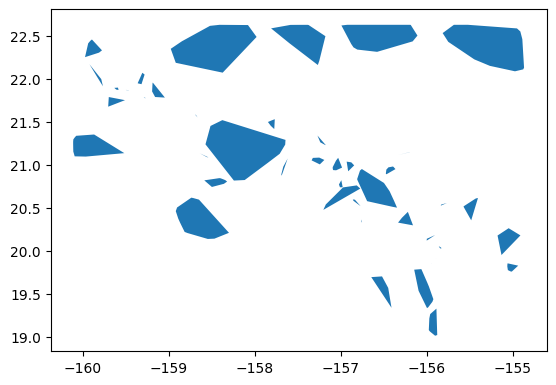

In [20]:
# quick plot the extracted polygons to check if everything worked fine
import geopandas
quick_plot = geopandas.GeoSeries(waypointsDF['PolygonObj'])
quick_plot.plot()

##### Routes identification

In [21]:
# for each LAT, LON pair, create a shapely.Point
concatDF['PointsObj'] = [shpl.Point(x,y) for (x,y) in concatDF[['LON', 'LAT']].values] #apparently this is faster than usig pandas.Dataframe.apply()

# for each WP, for each row of the entire dataset, check if the point is inside any WP
for name, polygon_obj in  waypointsDF[['Name', 'PolygonObj']].values:
    concatDF[str(name)] = polygon_obj.contains(concatDF['PointsObj']) # for each wp, create a new column containing either True or False

# list of column names just created
list_of_columns = [name for name in waypointsDF['Name']]

#idxmax: for each row, return the id (name) of the column containing the first occurrence of the maximum value. There are only bool values so True = 1 > False = 0
# basically returns the name of the WP where the point is contained. If the row has only 'False' values, it returns the first column (this is fixed below)
# this works under the assumption that any given point can belong to either zero or one WP.
concatDF['IsInWP'] = concatDF[list_of_columns].idxmax(axis=1)

# find all rows that have only 'False' values. The '~' negates the values (its like applying the binary NOT)
all_false_rows = concatDF[(~concatDF[list_of_columns]).all(axis=1)].index
# Replace the value in the 'IsInWP' column as 'None'
concatDF.loc[all_false_rows, 'IsInWP'] = None
# drop unnecessary columns
concatDF.drop(list_of_columns, axis=1, inplace=True)
concatDF.drop(['index', 'PointsObj'], axis=1, inplace=True)

display(concatDF.head(10))

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.10,entry,WP_42
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.500000,511.0,HARRIER,0,15,20,5,0.0,True,5.40,sailing,WP_42
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.06,sailing,WP_42
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.33,sailing,WP_42
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.000000,511.0,HARRIER,0,15,20,5,0.0,True,4.97,sailing,WP_42
5,382872,2019-01-08 19:38:24,21.3571,-157.9565,5.2,247.699997,511.0,HARRIER,0,15,20,5,0.0,True,4.86,sailing,WP_42
6,382872,2019-01-08 19:39:42,21.3563,-157.9584,5.2,242.199997,511.0,HARRIER,0,15,20,5,0.0,True,5.39,sailing,WP_42
7,382872,2019-01-08 19:41:03,21.3555,-157.9603,5.2,246.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.19,sailing,WP_42
8,382872,2019-01-08 19:42:13,21.3550,-157.9621,5.2,258.399994,511.0,HARRIER,0,15,20,5,0.0,True,5.41,sailing,WP_42
9,382872,2019-01-08 19:43:24,21.3546,-157.9638,5.2,257.899994,511.0,HARRIER,0,15,20,5,0.0,True,4.98,sailing,WP_42


IsInWP
WP_42    4087858
None      789331
WP_33     154376
WP_28      84391
WP_8       62181
WP_30      47115
WP_24      32081
WP_34      28753
WP_0       23756
WP_31      14372
WP_37      12338
WP_35       8441
WP_5        7523
WP_29       6830
WP_21       6027
WP_11       5940
WP_23       5441
WP_41       4135
WP_1        3556
WP_16       3515
WP_2        3172
WP_3        2997
WP_17       2976
WP_4        2810
WP_36       2436
WP_19       1871
WP_18       1681
WP_13       1577
WP_14        995
WP_39        959
WP_12        954
WP_22        905
WP_32        797
WP_27        748
WP_7         599
WP_6         390
WP_9         383
WP_15        291
WP_25        199
WP_26        140
WP_40        113
WP_38         83
WP_10         47
WP_20         46
Name: count, dtype: int64
(5415129, 17)


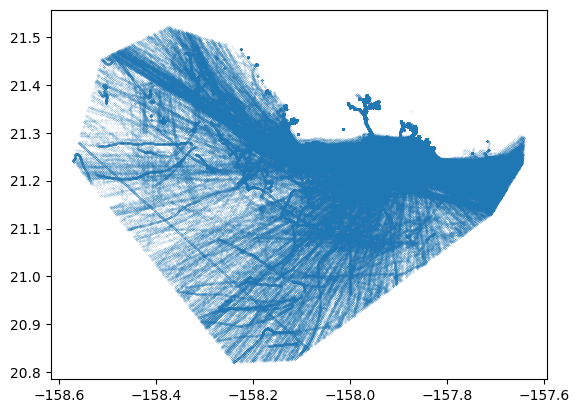

In [22]:
# count the number of points contained in each WP. 
# 'WP_X' -> the point is generated inside WP_X
# None -> the point does not belong to any cluster
value_counts = concatDF['IsInWP'].value_counts(dropna=False)
print(value_counts)
print(concatDF.shape)
# quick plot of the WP with the highest amount of points
testDF = concatDF[concatDF['IsInWP'] == value_counts.index[0]]
plt.scatter(testDF['LON'], testDF['LAT'], s=0.01)

#### Routes extraction
For each vessel contained in V_s (used at the beginning of this notebook), create a new column (called 'Route') specifying the current route.</br>If the ship is inside a WP, than the WP name is used in the new column.</br>If the ship is at open sea ('IsInWP' == None) then the Route column is filled in the following way:
* let A and B be the names of the start and end WPs, respectively. In order for them to be considered, they need to be either 'entry' or 'exit' WPs, or the vessel needs to generate at least one stationary point inside them
* if both A and B are known, the route name is built as A - B
* if either one is missing (pd.NA), the route name is built as "\<NA> - B" or "A - \<NA>"

In [23]:
concatDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype())
concatDF['Route'] = p.Series(dtype=p.StringDtype())
print(concatDF.shape)
for index, unique_mmsi in enumerate(reference_list_of_mmsi):
    vesselDF = concatDF[concatDF['MMSI'] == unique_mmsi].copy().reset_index(drop=True)
    vesselDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype()) # new empty column
    vesselDF['PreviousWP'] = p.Series(dtype=p.StringDtype())
    vesselDF['NextWP'] = p.Series(dtype=p.StringDtype())
    # extract the indeces of any entry-exit pair of points
    entry_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'entry'].index.to_list()
    exit_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'exit'].index.to_list()
    entry_exit_pairs_list = list(zip(entry_points_index, exit_points_index))
    # check formal validity of entry/exit pairs
    for idx, pair in enumerate(entry_exit_pairs_list):
        entry_idx, exit_idx = pair[0], pair[1]
        sub_range = range(entry_idx, exit_idx+1)            
        next_item = entry_exit_pairs_list[(idx + 1) % len(entry_exit_pairs_list)]
        if ((exit_idx + 1) != next_item[0]) and (idx+1 != len(entry_exit_pairs_list)):
            print(f'Error for tuples {pair}, {next_item} for vessel {unique_mmsi} with index {index}')
            break
        # if the pair is valid, extract the routes

        # create a new column for storing when a point is in a WP with a Avg_Speed lower than the threshold used for stationary points
        significantWP_condition = ( (vesselDF.loc[sub_range, 'Avg_Speed'] <= SPEED_THRESHOLD)
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'entry')
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'exit') 
                                   )

        vesselDF.loc[sub_range, 'IsInSignificantWP'] = np.where(significantWP_condition, vesselDF.loc[sub_range, 'IsInWP'], None)
  
        # create a new column where each row contains the name of the previous WP
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].ffill()
        
        # create a new column where each row contains the name of the following WP
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].bfill()
    
        #replace None values with pandas.NA, which is like np.NaN but for non-numeric values
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'PreviousWP'].fillna(p.NA)
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'NextWP'].fillna(p.NA)
        
        # create the route name as 'A - B'
        vesselDF.loc[sub_range, 'Route'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].combine_first(vesselDF.loc[sub_range, 'PreviousWP'].astype(str) + ' - ' + vesselDF.loc[sub_range, 'NextWP'].astype(str))

    # remove auxiliary columns that aren't necessary anymore
    vesselDF.drop(['PreviousWP', 'NextWP'], axis=1, inplace=True)
    #save df to the list of vessels (V_s)
    V_s[index] = vesselDF.copy()

concatDF = p.concat(V_s).copy()
#print(V_s[200][['BaseDateTime', 'MMSI', 'LAT', 'LON', 'EstimatedStatus', 'Avg_Speed', 'IsInWP','IsInSignificantWP', 'Route']].to_string())
display(V_s[0].loc[0:100])

(5415129, 19)


/tmp/ipykernel_9143/4203430550.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_9143/4203430550.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_9143/4203430550.py:42: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/tmp/ipykernel_9143/4203430550.py:42: FutureWarning:

The behavior of array concatenatio

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.10,entry,WP_42,WP_42,WP_42
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.500000,511.0,HARRIER,0,15,20,5,0.0,True,5.40,sailing,WP_42,<NA>,WP_42 - WP_42
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.06,sailing,WP_42,<NA>,WP_42 - WP_42
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.000000,511.0,HARRIER,0,15,20,5,0.0,True,5.33,sailing,WP_42,<NA>,WP_42 - WP_42
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.000000,511.0,HARRIER,0,15,20,5,0.0,True,4.97,sailing,WP_42,<NA>,WP_42 - WP_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,382872,2019-01-08 21:25:36,21.3532,-157.9402,0.0,93.300003,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,WP_42,WP_42,WP_42
97,382872,2019-01-08 21:26:46,21.3532,-157.9402,0.0,88.099998,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,WP_42,WP_42,WP_42
98,382872,2019-01-08 21:27:56,21.3532,-157.9402,0.0,82.699997,511.0,HARRIER,0,15,20,5,0.0,True,0.00,stationary,WP_42,WP_42,WP_42
99,382872,2019-01-08 21:29:07,21.3531,-157.9402,0.0,0.000000,511.0,HARRIER,0,15,20,5,0.0,True,0.30,stationary,WP_42,WP_42,WP_42


##### Plot ship path on a map

In [24]:
# dataframe structure should be the same of "concatDF"
def plot_routes(inputDF, mode):
    if inputDF.empty:
        print("No points to be plotted!")
    
    else:
        match mode:
            case "SingleVessel":
                output_title = "MMSI: " + str(inputDF.at[inputDF.index[0], 'MMSI'])
            case "SingleRoute":
                if type(inputDF.at[inputDF.index[0], 'Route']) == p.Series:
                    output_title = "Route: " + str(inputDF.at[inputDF.index[0], 'Route'].iloc[0])
                else:
                    output_title = "Route: " + str(inputDF.at[inputDF.index[0], 'Route'])
            case _: 
                print("Invalid plotting mode")

        # plot route points
        fig = px.scatter_mapbox(data_frame = inputDF,
                                    lon = inputDF['LON'],
                                    lat= inputDF['LAT'],
                                    zoom = 12,
                                    color = inputDF['Avg_Speed'],
                                    title = output_title,
                                    color_continuous_scale='portland',  #portland
                                    hover_data=inputDF[['BaseDateTime', 'Avg_Speed', 'Route', 'EstimatedStatus']]
                                    )

        # add domain border
        fig.add_trace(go.Scattermapbox(
                                        mode = 'lines',
                                        lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                        lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                        marker = {'size':10,
                                                  'color': 'red'},
                                        uid=2,
                                        below=0
                                        ))
    
        # Add polygons on map
        for label in clusteredPointsDF['Label'].unique():
            groupLATLONDF = clusteredPointsDF[clusteredPointsDF['Label']==label][['LAT', 'LON']]
            hull = ConvexHull(groupLATLONDF)
            hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
            hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]

            hull_lon = [serie.tolist()[1] for serie in hull_lon]
            hull_lat = [serie.tolist()[1] for serie in hull_lat]

            fig.add_trace(go.Scattermapbox(
                lat=hull_lat + [hull_lat[0]],
                lon=hull_lon + [hull_lon[0]],
                mode='lines',
                line=dict(color='black', width=2),
                below=0,
                showlegend=False,
                name='WP_' + str(label)
                #fill='toself',
                #fillcolor='rgba(255,0,0,0.2)'
            ))

        fig.update_layout(mapbox_style = 'open-street-map',
                          margin={'r':0, 't':40, 'l':0, 'b':0},
                          )
        po.plot(fig)

# 3 5 12
to_be_plotted = V_s[5]
plot_routes(to_be_plotted, "SingleVessel")

#### Search for the most popular routes

In [25]:
def count_groups(df, col_name):
    df['shifted'] = df[col_name].shift(1)
    df['change'] = df[col_name] != df['shifted']
    df['group'] = df['change'].cumsum()
    group_counts = df.groupby('group')[col_name].first().value_counts()
    return group_counts

result = {}

for temp_vessel in V_s:
    group_counts = count_groups(temp_vessel, 'Route')
    for key, count in group_counts.items():
        if key not in result.keys():
            result[key] = count
        else:
            result[key] += count

tempDF = p.DataFrame(data={'Name': result.keys(), 'Count': result.values()}).sort_values(by='Count', ascending=False).to_string()
print(tempDF)
#display(tempDF[tempDF['Name'].str.contains('WP_4') == True])

              Name  Count
1            WP_42  27161
0    WP_42 - WP_42  25960
38           WP_33   3592
40   WP_33 - WP_33   3231
58            WP_8   1983
59     WP_8 - WP_8   1839
68           WP_28   1206
21           WP_30   1096
22   WP_30 - WP_30   1040
85   WP_28 - WP_28   1037
23           WP_24    527
30   WP_24 - WP_24    429
24            WP_0    429
6     WP_42 - <NA>    423
11    <NA> - WP_42    403
115   WP_0 - WP_33    298
34    WP_33 - WP_0    292
41           WP_34    227
31           WP_29    181
42   WP_34 - WP_34    179
185  WP_29 - WP_29    163
110  WP_42 - WP_28    148
53           WP_16    128
66   WP_28 - WP_42    127
35     WP_0 - WP_0    123
106          WP_37    111
243          WP_41    100
244  WP_41 - WP_41     98
65    WP_8 - WP_42     97
60    WP_42 - WP_8     95
43           WP_21     91
129  WP_24 - WP_42     84
128  WP_42 - WP_24     79
212          WP_32     75
213  WP_32 - WP_32     74
4             WP_5     68
45   WP_21 - WP_21     64
161         

In [26]:
# plot all points given a certain route

route_name = 'WP_28' + ' - ' + 'WP_42'
#route_name = "WP_28"
chosen_points = concatDF[concatDF['Route'] == route_name].copy()
#display(chosen_points)
plot_routes(chosen_points, mode="SingleRoute")

# Store dataframe in order to share it between notebooks
%store chosen_points


Stored 'chosen_points' (DataFrame)
